## Goals:

1. Find maximum-likelihood parameters for a model using gradient descent algorithms (based on SSE or LL)
2. Model comparison using AIC and BIC
3. Model and parameter recovery

## Load packages

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = os.path.realpath('.')
print(base_dir)

/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial


## Writing choice rules

In [3]:
def greedy(utilities, params = []):
    
    choice = np.where(utilities == np.max(utilities))[0][0]
    
    return choice

In [4]:
def e_greedy(utilities, epsilon):
    
    random_number = np.random.rand()
    
    if random_number < epsilon:
        # Choose randomly
        choice = np.random.randint(0,2)
    else:
        # Choose deterministically
#         choice = np.where(utilites == np.max(utilities))
        choice = greedy(utilities)
    
    return choice

In [5]:
def softmax_with_choice(utilities, beta):
    # Beta is sometimes called 'inverse temperature' or 'explore parameter'
    
    # Version for choice A only => then prob_B will be 1 - prob_A
    prob_A = (np.exp(utilities[0] * beta) /
              (np.exp(utilities[0] * beta) + np.exp(utilities[1] * beta)))
    
    # General version (this works too, try it out!)
    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    random_number = np.random.rand()
    if random_number < prob_A:
        choice = 0
    else:
        choice = 1
    
    return choice

In [6]:
def softmax(utilities, beta):

    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    return probs

##### Define our inequity aversion model again:

In [7]:
def inequity_aversion(offer, alpha):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = np.array([offer, 0])
    inequities = np.array([(100-offer)-offer, 0])
    utilities = payoffs - np.multiply(alpha,inequities)

    return utilities

##### Simulate data for inequity aversion + softmax with varying parameter values

In [59]:
def simulate_data(sub_data, alpha, beta, evaluate_choices = False):
    simulated_data = pd.DataFrame()
    for trial in sub_data['trial'].unique():
        trial_data = sub_data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        
        # Value function: inequity aversion ==> utilities
        utilities = inequity_aversion(offer, alpha)
        
        # Choice rule: softmax ==> probabilities
        choice_probabilities = softmax(utilities, beta)
        
        # Make a choice
        if evaluate_choices:
            choice = 0 if np.random.rand() < choice_probabilities[0] else 1
        
        # Store results
        if evaluate_choices:
            simulated_data = simulated_data.append(pd.DataFrame(
                [[trial, offer, choice_probabilities[0], choice]],
                columns=['trial', 'offer', 'probability_accept', 'choice'])).reset_index(drop=True)
        else:
            simulated_data = simulated_data.append(pd.DataFrame(
                [[trial, offer, choice_probabilities[0]]],
                columns=['trial', 'offer', 'probability_accept'])).reset_index(drop=True)
    return simulated_data

## Using the SciPy package to fit the model for us

1. Load Joey's data again
2. Tell the SciPy.Optimise. to find the best fitting parameters

##### Load some data

In [9]:
data = pd.read_csv(base_dir + '/Data/Study1_UG.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


Single subject:

In [10]:
sub = 2
sub_data = data.query('sub == @sub').reset_index(drop=True)
sub_data.head()

,sub,trial,unfairness,choice,offer
0,2,1,60,0,40
1,2,2,55,0,45
2,2,3,85,1,15
3,2,4,95,1,5
4,2,5,65,0,35


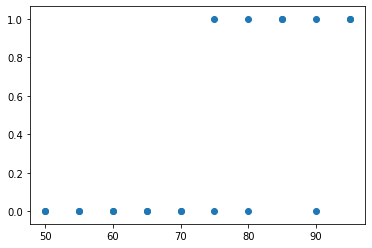

In [11]:
plt.scatter(sub_data['unfairness'], sub_data['choice'])

##### Implement the optimization routine

In [12]:
def compute_negloglike(params, data):
    
    alpha = params[0]
    beta = params[1]
    
    # For each trial, compute the probability of observing THIS PARTICULAR BEHAVIOR given alpha and beta
    trial_probs = []
    for trial in data['trial'].unique():
        trial_data = data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        choice = trial_data['choice'].values[0]
        utilities = inequity_aversion(offer, alpha)
        choice_probabilities = softmax(utilities, beta)
        prob_of_observed = choice_probabilities[choice]
        trial_probs.append(prob_of_observed)
    
    # Multiply the probabilities of all trials to get the likelihood of the whole dataset –– here use the log trick!
    loglike = np.sum(np.log(trial_probs))
    
    return -loglike

In [13]:
import tqdm

In [14]:
n_iter = 10
objective_function = lambda params: compute_negloglike(params, sub_data)
fit_results = pd.DataFrame()
for i in tqdm.tqdm(range(n_iter)):
    x0 = np.random.rand(2)
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[i, best_params, best_NLL]],
                                     columns = ['iteration','best_params','best_NLL']))

 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 42
         Function evaluations: 81


 20%|██        | 2/10 [00:04<00:18,  2.33s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 31
         Function evaluations: 59


 30%|███       | 3/10 [00:06<00:16,  2.29s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 36
         Function evaluations: 68


 40%|████      | 4/10 [00:08<00:13,  2.22s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 38
         Function evaluations: 73


 50%|█████     | 5/10 [00:11<00:12,  2.45s/it]

Optimization terminated successfully.
         Current function value: 6.392668
         Iterations: 51
         Function evaluations: 97


 60%|██████    | 6/10 [00:15<00:10,  2.74s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 43
         Function evaluations: 83


 70%|███████   | 7/10 [00:17<00:08,  2.74s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 38
         Function evaluations: 73


 80%|████████  | 8/10 [00:20<00:05,  2.66s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 34
         Function evaluations: 63


 90%|█████████ | 9/10 [00:22<00:02,  2.64s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 40
         Function evaluations: 75


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 44
         Function evaluations: 83


In [16]:
fit_results.sort_values(by='best_NLL')

,iteration,best_params,best_NLL
0,4,"[0.32890087483886776, 0.11684241888083689]",6.392668
0,8,"[0.32890205253536675, 0.1168588921941674]",6.392669
0,0,"[0.32889000856217804, 0.11686632280656636]",6.392669
0,5,"[0.3288499453041194, 0.1168621759008255]",6.392669
0,2,"[0.3288563430615493, 0.11684326866808417]",6.392669
0,7,"[0.3288602574215953, 0.11683971959432654]",6.392669
0,3,"[0.3289131943108281, 0.11684018315539903]",6.392669
0,6,"[0.3288350335293181, 0.11686596363537857]",6.392669
0,1,"[0.32892608529911516, 0.11683956881099716]",6.392669
0,9,"[0.32883625212046597, 0.11684374703687117]",6.392669


## Say you want to send this data to the GitHub repository for others to see

In [25]:
fit_results.to_csv(base_dir + '/Results/fit_onesub_jeroen.csv')

Now use git command line or GitHub Desktop to push this file to the repo (outside of notebook)

In [27]:
!ls Results

Study1_UG_Fits_Joey.csv fit_onesub_jeroen.csv


## Find the best-fitting parameters for all subjects using scipy.optimize.fmin

Homework:
1. Fit model for all subjects - find a good number of iterations to try
2. Plot the best-fitting parameters for all subjects
3. Do parameter recovery: a) pick 10 sets of parameters (alpha & beta), b) simulate data for each set, c) fit the model to the simulated data, d) repeat b and c 100 times, e) compare the 'recovered' parameters to the ones you picked in step a).

## Load Joey's model fit results

In [29]:
model_fits_allsubs = pd.read_csv(base_dir + '/Results/Study1_UG_Fits_Joey.csv',index_col=0)
model_fits_allsubs.head()

,sub,alpha,beta,log_lik
1,1,-0.847179,0.812091,0.000000
2,2,0.328861,0.116852,-6.392668
3,3,-0.466158,0.844786,0.000000
4,4,0.611098,0.068869,-7.950943
5,5,0.214286,5.286248,-1.386294


##### Visualize the fitted parameters:

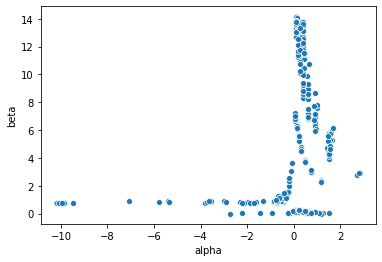

In [35]:
sns.scatterplot(x = model_fits_allsubs.query('alpha < 10')['alpha'],
               y = model_fits_allsubs.query('alpha < 10')['beta'])

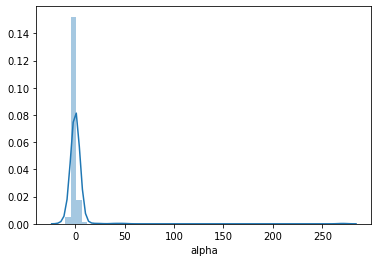

In [39]:
sns.distplot(model_fits_allsubs['alpha'], bins = 50)

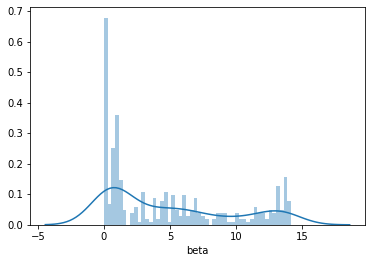

In [38]:
sns.distplot(model_fits_allsubs['beta'], bins = 50)

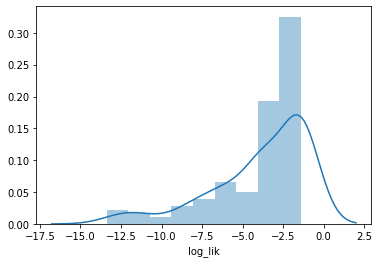

In [45]:
sns.distplot(model_fits_allsubs.query('log_lik < -.1')['log_lik'])

##### Compare to Lotte's results

In [51]:
model_fits_lotte = pd.read_csv(base_dir + '/Results/Model_fit_results_Lotte.csv',
                              index_col = 0)
model_fits_lotte = model_fits_lotte.rename(columns = {'subject':'sub','tot_best_NLL':'NLL'})
model_fits_lotte['log_lik'] = -model_fits_lotte['NLL']
model_fits_lotte.head()

,sub,alpha,beta,NLL,log_lik
0,2,0.328821,0.116842,6.392669,-6.392669
0,3,-0.576554,1.176875,-0.000000,0.000000
0,4,0.611046,0.068872,7.950943,-7.950943
0,5,0.214286,5.020193,1.386294,-1.386294
0,6,0.412874,9.383481,-0.000000,0.000000


In [52]:
model_fits_joeylotte = model_fits_allsubs.merge(model_fits_lotte,
                           on = 'sub', suffixes = ['_joey','_lotte'])

In [53]:
model_fits_joeylotte.head()

,sub,alpha_joey,beta_joey,log_lik_joey,alpha_lotte,beta_lotte,NLL,log_lik_lotte
0,2,0.328861,0.116852,-6.392668,0.328821,0.116842,6.392669,-6.392669
1,3,-0.466158,0.844786,0.000000,-0.576554,1.176875,-0.000000,0.000000
2,4,0.611098,0.068869,-7.950943,0.611046,0.068872,7.950943,-7.950943
3,5,0.214286,5.286248,-1.386294,0.214286,5.020193,1.386294,-1.386294
4,6,0.408515,8.274810,0.000000,0.412874,9.383481,-0.000000,0.000000


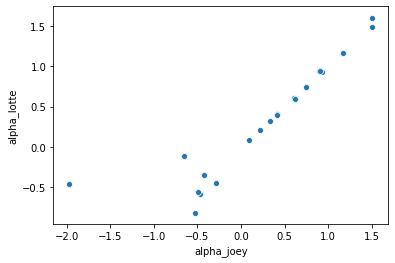

In [54]:
sns.scatterplot(model_fits_joeylotte['alpha_joey'],
                model_fits_joeylotte['alpha_lotte'])

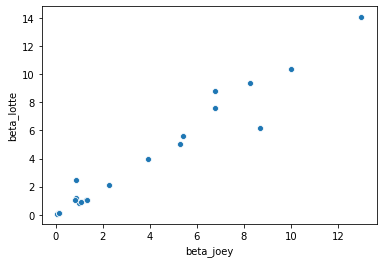

In [55]:
sns.scatterplot(model_fits_joeylotte['beta_joey'],
                model_fits_joeylotte['beta_lotte'])

This looks pretty good: it seems like the subjects with alpha > 0 gave consistent results, while subjects with alpha < 0 gave erratic estimates for alpha. This means that alpha is not as well interpretable with < 0 values, which we can also conclude by reasoning about the model since all different alpha < 0 will yield the same result where the subject always accepts an UG offer.

Actually going back to the original Fehr & Schmidt (1999) paper, where the IA model is proposed, they say alpha must be >= 0.

So if we wanted, we could run the model again with that constraint.

##### Summary: how to deal with unreliable parameter fits?

1. Run the model more times to avoid local maxima.
2. Apply boundaries to the model parameters, based on the theory behind the model or simulations of the model. E.g. Capping beta at 10, or writing the model such that alpha is between 0 and 1 with 0 meaning only caring about payoff and 1 meaning only caring about inequity.
3. Run parameter recovery to test if the fits are reliable or not.

## Parameter recovery

##### Logic:

1. Create a 'ground truth' model for which you KNOW the parameter values.
2. Simulate data from that ground truth model.
3. Fit your model to the simulated data to see if you can RECOVER the known parameters.

In [81]:
# Step 1: pick some ground truth alphas and betas
alpha = 1
beta = 2

In [82]:
# Step 2: simulate data
sim_data = simulate_data(sub_data, alpha, beta, evaluate_choices = True)
sim_data.head()

,trial,offer,probability_accept,choice
0,1,40,1.000000e+00,0
1,2,45,1.000000e+00,0
2,3,15,1.688912e-48,1
3,4,5,1.478898e-74,1
4,5,35,9.999546e-01,0


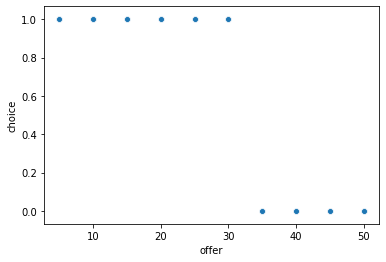

In [85]:
sns.scatterplot(data = sim_data, x = 'offer', y = 'choice')

In [90]:
# Step 3: fit model to these simulated data
n_iter = 10
objective_function = lambda params: compute_negloglike(params, sim_data)
fit_results = pd.DataFrame()
for i in range(n_iter):
    x0 = np.random.rand(2)
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[i, best_params[0], best_params[1], best_NLL]],
                                     columns = ['iteration','alpha','beta','best_NLL']))

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 40
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 59
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 49
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 41
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 77
         Function evaluations: 172
Optimization terminat

In [91]:
best_NLL = np.min(fit_results['best_NLL'])
print(best_NLL)

-0.0


In [92]:
best_solutions = fit_results.query('best_NLL == @best_NLL').copy()

In [100]:
best_solutions.head()

,iteration,alpha,beta,best_NLL
0,0,0.864507,8.344201,-0.0
0,1,0.924663,7.022454,-0.0
0,2,0.948115,5.900576,-0.0
0,3,0.897796,6.494606,-0.0
0,4,0.937512,7.862938,-0.0


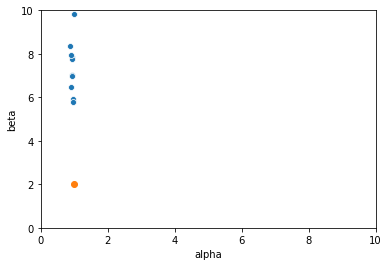

In [97]:
sns.scatterplot(data = best_solutions, x = 'alpha', y = 'beta')
plt.xlim([0,10]); plt.ylim([0,10]);
plt.scatter(alpha,beta)

In [103]:
best_solution = best_solutions.iloc[0]
best_solution

iteration    0.000000
alpha        0.864507
beta         8.344201
best_NLL    -0.000000
Name: 0, dtype: float64

In [107]:
sim_best = simulate_data(sub_data, best_solution['alpha'], best_solution['beta'], evaluate_choices=True)

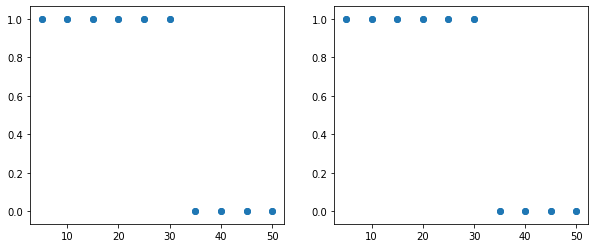

In [108]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])
ax[0].scatter(sim_data['offer'], sim_data['choice'])
ax[1].scatter(sim_best['offer'], sim_best['choice'])

The parameters don't fit exactly but the data is the same... we therefore need more data in our experiment to get a more precise match of recovered to true parameters!

In [113]:
# Step 2: simulate data
sim_data = pd.DataFrame()
for n_experiments in range(100):
    to_append = simulate_data(sub_data, alpha, beta, evaluate_choices = True)
    sim_data = sim_data.append(to_append)
sim_data.head()

,trial,offer,probability_accept,choice
0,1,40,1.000000e+00,0
1,2,45,1.000000e+00,0
2,3,15,1.688912e-48,1
3,4,5,1.478898e-74,1
4,5,35,9.999546e-01,0


In [114]:
# Step 3: fit model to these simulated data
n_iter = 10
objective_function = lambda params: compute_negloglike(params, sim_data)
fit_results = pd.DataFrame()
for i in range(n_iter):
    x0 = np.random.rand(2)
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[i, best_params[0], best_params[1], best_NLL]],
                                     columns = ['iteration','alpha','beta','best_NLL']))

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 50
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 56
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 47
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 57
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 53
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 35
         Function evaluations: 96
Optimization terminat

In [115]:
best_solutions = fit_results.query('best_NLL == @best_NLL').copy()

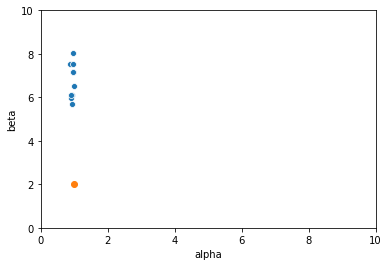

In [116]:
sns.scatterplot(data = best_solutions, x = 'alpha', y = 'beta')
plt.xlim([0,10]); plt.ylim([0,10]);
plt.scatter(alpha,beta)

In [119]:
sim_data_agg = sim_data.groupby(['offer'], as_index=False).mean()

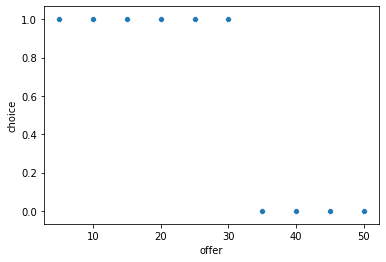

In [120]:
sns.scatterplot(data = sim_data_agg, x = 'offer', y = 'choice')

##### Let's try other alphas and betas

In [134]:
alphas = np.arange(0,2,.4)
betas = np.arange(0,1,.2)
alphas, betas

(array([0. , 0.4, 0.8, 1.2, 1.6]), array([0. , 0.2, 0.4, 0.6, 0.8]))

In [135]:
n_iter = 1
recovery_results = pd.DataFrame()
for alpha in alphas:
    print(alpha)
    for beta in betas:
        sim_data = simulate_data(sub_data, alpha, beta, evaluate_choices=True)
        # Fit the model
        objective_function = lambda params: compute_negloglike(params, sim_data)
        fit_results = pd.DataFrame()
        for i in range(n_iter):
            x0 = np.random.rand(2)
            out = scipy.optimize.fmin(objective_function, x0, full_output=True)
            best_params, best_NLL = out[:2]
            fit_results = fit_results.append(pd.DataFrame([[i, best_params[0], best_params[1], best_NLL]],
                                             columns = ['iteration','alpha','beta','best_NLL']))
        to_append = pd.DataFrame([[alpha, beta, best_params[0], best_params[1], best_NLL]],
                                 columns = ['true_alpha','true_beta','recov_alpha','recov_beta','NLL'])
        recovery_results = recovery_results.append(to_append)

0.0
Optimization terminated successfully.
         Current function value: 13.612110
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 2.989885
         Iterations: 52
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 22
         Function evaluations: 70


<ipython-input-6-be67f20bb439>:3: RuntimeWarning: overflow encountered in exp
  probs = (np.exp(np.multiply(utilities, beta)) /
<ipython-input-6-be67f20bb439>:4: RuntimeWarning: overflow encountered in exp
  (np.sum(np.exp(np.multiply(utilities, beta)))))
<ipython-input-6-be67f20bb439>:3: RuntimeWarning: invalid value encountered in true_divide
  probs = (np.exp(np.multiply(utilities, beta)) /


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 25
         Function evaluations: 75
0.4
Optimization terminated successfully.
         Current function value: 6.392669
         Iterations: 32
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 147
         Function evaluations: 295
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 51
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 44
         Function evaluations: 114
0.8
Optimization terminated successfully.
         Current function value: 13.753498
         Iterations: 56
         Function evaluations: 108
Optimization ter

In [136]:
recovery_results.head()

,true_alpha,true_beta,recov_alpha,recov_beta,NLL
0,0.0,0.0,1.831907,0.003709,1.361211e+01
0,0.0,0.2,-0.024639,0.158340,2.989885e+00
0,0.0,0.4,-0.497701,1.083268,-0.000000e+00
0,0.0,0.6,-11.759702,0.666759,6.661338e-15
0,0.0,0.8,-3.428243,0.839430,-0.000000e+00


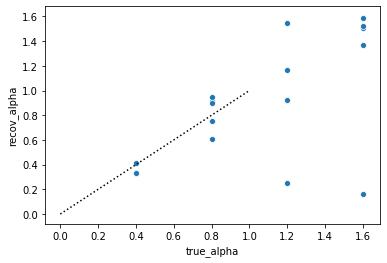

In [141]:
sns.scatterplot(data = recovery_results.query('recov_alpha < 2 and true_alpha > 0'),
                x = 'true_alpha', y = 'recov_alpha')
plt.plot([0,1],[0,1],'k:')

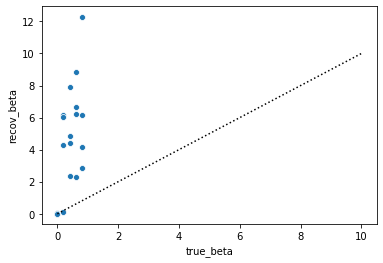

In [138]:
sns.scatterplot(data = recovery_results.query('recov_alpha < 2 and true_alpha > 0'),
                x = 'true_beta', y = 'recov_beta')
plt.plot([0,10],[0,10],'k:')

So it looks like, barring the known issues at alpha == 0, both alpha and beta can be recovered well even though we only have 20 trials in our experiment.

HOMEWORK: FIGURE THIS OUT!

## Next:

1. Talk about model comparison between model classes (first inequity aversion model vs random choice model using log likelihood, then if we want hidden multiplier trust game social preference models using sum of squared error)
2. Summarize what we've seen so far. Take a step back and talk about why it's useful what we've done and what we're still lacking. What do we still need?
3. Other model types - RL, DDM etc